# Pyramidal-Interneuronal Network Gamma (PING)

## Introduction

## Neuron Model

E-cell is a Reduced Traub-Miles (RTM) neuron [1], and I-cell is a Wang-Buzsáki (WB) neuron [2]. 

Both RTM and WB originate from Hodgkin-Huxley (HH) model, with different parameters modelling different neuronal dynamics of regular-spiking (RS) pyramidal E-neurons and fast-spiking (FS) PV+ I-neurons.

### 1. HH model

The standard HH model can be formulated as

$$C\frac{\mathrm dV}{\mathrm dt}=-I_{\mathrm{Na}}-I_{\mathrm{K}}-I_{\mathrm{L}}+I_{\mathrm{syn}}+I_{\mathrm{app}},$$

where

\begin{align*}
I_{\mathrm{Na}}&=g_{\mathrm{Na}}m^3h(V-E_{\mathrm{Na}}),\\
I_{\mathrm{K}}&=g_{\mathrm{K}}n^4(V-E_{\mathrm{K}}),\\
I_{\mathrm{L}}&=g_{\mathrm{L}}(V-E_{\mathrm{L}}).
\end{align*}

Notation:

- $C$: membrane capacitance
- $V$: membrane potential
---
- $I_{\mathrm{Na}}$: sodium current
- $I_{\mathrm{K}}$: potassium current
- $I_{\mathrm{L}}$: leak current
- $I_{\mathrm{syn}}$: synaptic input current
- $I_{\mathrm{app}}$: injected input current
---
- $g_{\mathrm{Na}}$: maximal sodium conductance
- $g_{\mathrm{K}}$: maximal potassium conductance
- $g_{\mathrm{L}}$: leak conductance
---
- $E_{\mathrm{Na}}$: sodium reversal potential
- $E_{\mathrm{K}}$: potassium reversal potential
- $E_{\mathrm{L}}$: leak reversal potential
---
- $m$: sodium activation gating variable
- $h$: sodium inactivation gating variable
- $n$: potassium activation gating variable

### 2. RTM model

In RTM model, only variable $n$ obeys first-order kinetics:

$$\frac{\mathrm dn}{\mathrm dt}=\alpha_n(V)(1-n) - \beta_n(V).$$

Variables $m$ is assumed fast and substituted by its steady-state function:

$$m_{\infty}(V)=\frac{\alpha_m(V)}{\alpha_m(V)+\beta_m(V)}.$$

Variable $h$ is set as a linear function of $n$:

$$h=\max(1 - 1.25 n, 0)$$

We use the following parameters for RTM model, which are originally from [1].

Parameters:

- $C = 1\mu F/\mathrm{cm}^2$
---
- $g_{\mathrm{Na}}=100 \mathrm{mS/cm}^2$
- $E_{\mathrm{Na}}=50 \mathrm{mV}$
- $\alpha_m(V)= \frac{0.32(V+54)}{1-\exp(-0.25(V+54))}$
- $\beta_m(V)=\frac{0.28(V+27)}{\exp[0.2(V+27)-1]}$
---
- $g_{\mathrm{K}}=80 \mathrm{mS/cm}^2$
- $E_{\mathrm{K}}=-100\mathrm{mV}$
- $\alpha_n(V)=\frac{0.032(V+52)}{1-\exp(-0.2(V+52))}$
- $\beta_n(V) =0.5\exp\left(-0.025(V+57)\right)$
---
- $g_{\mathrm{L}} = 0.1\mathrm{mS/cm}^2$
- $E_{\mathrm{L}} = -67\mathrm{mV}$

### 3. WB model

In WB model, variables $h,n$ follow first-order kinetics:

$$
\frac{\mathrm dx}{\mathrm dt}=\phi\left[\alpha_x(V)(1-x)-\beta_x(V)x\right],\quad x\in\{h,n\},
$$

where $\phi$ is a scaling factor. Variable $m$ is also assumed fast and substituted by its steady-state function 

$$m_{\infty}(V)=\frac{\alpha_m(V)}{\alpha_m(V)+\beta_m(V)}.$$

We use the following parameters for WB model, which are originally from [2].

Parameters:

- $C = 1\mu F/\mathrm{cm}^2$
---
- $g_{\mathrm{Na}}=35 \mathrm{mS/cm}^2$
- $E_{\mathrm{Na}}=55 \mathrm{mV}$
- $\alpha_m(V)= \frac{0.1(V+35)}{1-\exp(-0.1(V+35))}$
- $\beta_m(V)=4\exp\left(\frac{-(V+60)}{18}\right)$
- $\alpha_h(V)=0.07\exp\left(-0.05(V+58)\right)$
- $\beta_h(V)=\frac{1}{\exp(-0.1(V+28)) + 1}$
---
- $g_{\mathrm{K}}=9 \mathrm{mS/cm}^2$
- $E_{\mathrm{K}}=-90 \mathrm{mV}$
- $\alpha_n(V)= \frac{0.01(V+34)}{1-\exp(-0.1(V+34))}$
- $\beta_n(V) = 0.125\exp\left(-0.0125(V+44)\right)$
---
- $g_{\mathrm{L}} = 0.1 \mathrm{mS/cm}^2$
- $E_{\mathrm{L}} = -65 \mathrm{mV}$
---
- $\phi = 5$

> Note that parameters of synapses and network connectivity are not included here. They will be introduced in the following sections.

### 4. Implementation

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# =========================================================
# Base Neuron Model Class
# =========================================================
class NeuronModel:
    def __init__(self, params):
        self.params = params
        
    def alpha_beta(self, V):
        raise NotImplementedError
        
    def derivatives(self, state, t, I_inj):
        raise NotImplementedError

# =========================================================
# RTM model
# Corresponds to pyramidal excitatory neurons
# 2 state variables [V, n], h is a function of n
# =========================================================
class RTMNeuron(NeuronModel):
    def __init__(self):
        params = {
            'C': 1.0,
            'g_Na': 100.0, 'E_Na': 50.0,
            'g_K': 80.0,   'E_K': -100.0,
            'g_L': 0.1,    'E_L': -67.0
        }
        super().__init__(params)

    def derivatives(self, state, t, I_inj):
        V, n = state
        p = self.params
        eps = 1e-8
        
        # alpha_m, beta_m
        # alpha_m = 0.32(V+54) / (1 - exp(-0.25(V+54)))
        # beta_m = 0.28(V+27) / (exp(0.2(V+27)) - 1)
        num_am = 0.32 * (V + 54)
        den_am = 1.0 - np.exp(-0.25 * (V + 54))
        alpha_m = num_am / (den_am + eps) if abs(den_am) > eps else 0.32 / 0.25
        num_bm = 0.28 * (V + 27)
        den_bm = np.exp(0.2 * (V + 27)) - 1.0
        beta_m = num_bm / (den_bm + eps) if abs(den_bm) > eps else 0.28 / 0.2
        m_inf = alpha_m / (alpha_m + beta_m)

        # alpha_n, beta_n
        # alpha_n = 0.032(V+52) / (1 - exp(-0.2(V+52)))
        # beta_n = 0.5exp(-0.025(V+57))
        num_an = 0.032 * (V + 52)
        den_an = 1.0 - np.exp(-0.2 * (V + 52))
        alpha_n = num_an / (den_an + eps) if abs(den_an) > eps else 0.032 / 0.2 # L'Hopital rule
        beta_n = 0.5 * np.exp(-(V + 57) / 40.0)
        
        # h is a function of n
        h = max(1.0 - 1.25 * n, 0.0)
        
        # channel currents
        I_Na = p['g_Na'] * (m_inf**3) * h * (V - p['E_Na'])
        I_K  = p['g_K']  * (n**4) * (V - p['E_K'])
        I_L  = p['g_L']  * (V - p['E_L'])
        
        # update states
        dVdt = (-I_Na - I_K - I_L + I_inj) / p['C']
        dndt = alpha_n * (1 - n) - beta_n * n
        
        return [dVdt, dndt]

# =========================================================
# WB model
# Corresponds to PV+ inhibitory neurons
# 3 state variables [V, h, n]
# =========================================================
class WBNeuron(NeuronModel):
    def __init__(self):
        params = {
            'C': 1.0,
            'g_Na': 35.0,  'E_Na': 55.0,
            'g_K': 9.0,    'E_K': -90.0,
            'g_L': 0.1,    'E_L': -65.0,
            'phi': 5.0
        }
        super().__init__(params)

    def derivatives(self, state, t, I_inj):
        V, h, n = state
        p = self.params
        phi = p['phi']
        eps = 1e-8
        
        # alpha_m, beta_m
        # alpha_m = 0.1(V+35) / (1 - exp(-0.1(V+35)))
        # beta_m = 4exp(-(V+60)/18)
        num_am = 0.1 * (V + 35)
        den_am = 1.0 - np.exp(-0.1 * (V + 35))
        alpha_m = num_am / (den_am + eps) if abs(den_am) > eps else 1.0
        beta_m = 4.0 * np.exp(-(V + 60) / 18.0)
        m_inf = alpha_m / (alpha_m + beta_m)
        
        # alpha_n, beta_n
        # alpha_n = 0.01(V+34) / (1 - exp(-0.1(V+34)))
        # beta_n = 0.125exp(-(V+44)/80)
        num_an = 0.01 * (V + 34)
        den_an = 1.0 - np.exp(-0.1 * (V + 34))
        alpha_n = num_an / (den_an + eps) if abs(den_an) > eps else 0.1
        beta_n = 0.125 * np.exp(-(V + 44) / 80.0)

        # alpha_h, beta_h
        alpha_h = 0.07 * np.exp(-(V + 58) / 20.0)
        beta_h  = 1.0 / (np.exp(-0.1 * (V + 28)) + 1.0)
        
        # channel currents
        I_Na = p['g_Na'] * (m_inf**3) * h * (V - p['E_Na'])
        I_K  = p['g_K']  * (n**4) * (V - p['E_K'])
        I_L  = p['g_L']  * (V - p['E_L'])
        
        # update states
        dVdt = (-I_Na - I_K - I_L + I_inj) / p['C']
        dhdt = phi * (alpha_h * (1 - h) - beta_h * h)
        dndt = phi * (alpha_n * (1 - n) - beta_n * n)
        
        return [dVdt, dhdt, dndt]

In [62]:
# =========================================================
# simulation: inject const current to both neurons
# =========================================================
def run_simulation(I_RTM=1.0, I_WB=1.0, t_max=200.0):
    dt = 0.01
    t = np.arange(0, t_max, dt)
    
    rtm = RTMNeuron()
    wb = WBNeuron()
    
    # initialize states
    state0_rtm = [-67.0, 0.0] # [V, n]
    state0_wb = [-65.0, 1.0, 0.0] # [V, h, n]

    # solve ODEs
    sol_rtm = odeint(rtm.derivatives, state0_rtm, t, args=(I_RTM,))
    sol_wb = odeint(wb.derivatives, state0_wb, t, args=(I_WB,))
    
    # plot results
    plt.figure(figsize=(12, 6))
    
    # plot RTM
    plt.subplot(2, 1, 1)
    plt.title(f"RTM neuron (RS, excitatory), injected currents = {I_RTM} $\\mathrm{{\mu A/cm^2}}$, no synaptic input")
    plt.plot(t, sol_rtm[:, 0], color='red', alpha=0.7)
    plt.ylabel("V (mV)")
    plt.grid(True, which='both', linestyle='--', alpha=0.5)
    # plt.legend()
    
    # plot WB
    plt.subplot(2, 1, 2)
    plt.title(f"WB neuron (FS, inhibitory), injected currents = {I_WB} $\\mathrm{{\mu A/cm^2}},$ no synaptic input")
    plt.plot(t, sol_wb[:, 0], color='blue', alpha=0.7)
    plt.ylabel("V (mV)")
    plt.xlabel("Time (ms)")
    plt.grid(True, which='both', linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.show()

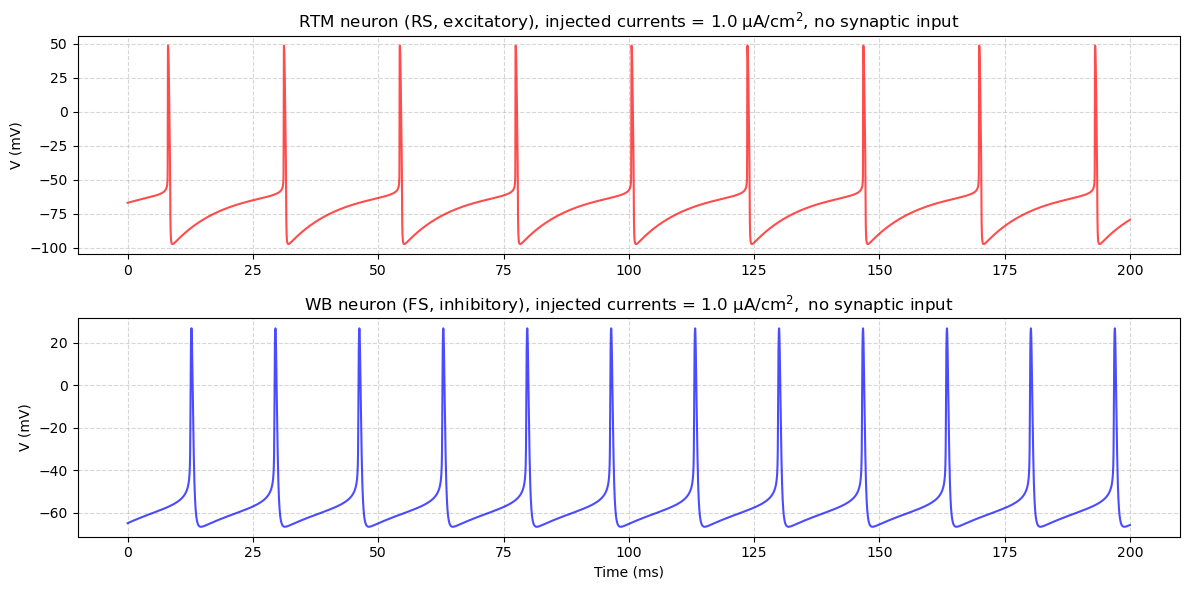

In [63]:
# Play with the neuron models :)
run_simulation(I_RTM=1.0, I_WB=1.0, t_max=200.0)

## Two-cell PING

## References
[1] G.B. Ermentrout, & N. Kopell, Fine structure of neural spiking and synchronization in the presence of conduction delays. *PNAS*, 1998.

[2] Wang, X. J., & Buzsáki, G. Gamma oscillation by synaptic inhibition in a hippocampal interneuronal network model. *Journal of Neuroscience*, 1996.